In [2]:
# Using drugMLpractical environment
# Need python < 3.12 so I have 3.11, then just pip install matplotlib, pip install 'molflux[rdkit]'

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import rdkit.Chem as Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Descriptors

def read_and_clean_data(path):
    df = pd.read_csv(path)
    df = df.dropna(subset=['r_avg_IC50', 'f_avg_IC50'], how='all') # removing na values
    df = df.drop_duplicates(subset=['SMILES'], keep='first') # removing the duplicates --> show example? 
    df = df[df['f_avg_IC50']<=100] # removes extreme outliers
    dfs = df[['SMILES','CID','f_avg_IC50','r_avg_IC50']]
    return df, dfs

df, dfs = read_and_clean_data('raw_df_notest.csv')

/var/folders/0n/tfjdd1157tj4k9w96w40kyn00000gn/T/ipykernel_25459/2626674935.py:13: DtypeWarning: Columns (4,7,8,10,11,12,13,14,15,16,17,18,19,20,28,29,30,31,32,33,34,35,36,37,41,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,67,68,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,250,254,255,256,257,258,259,260,265,266,267,268,269,270,271,276,277) have mixed types. Specify dtype option on im

In [3]:
dfs["log10_f_avg_IC50"] = - np.log10(dfs["f_avg_IC50"]*1e-6) 

from datasets import Dataset

import pandas as pd
data = Dataset.from_pandas(dfs)
print(data)
data[0]

/var/folders/0n/tfjdd1157tj4k9w96w40kyn00000gn/T/ipykernel_25459/1542293824.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["log10_f_avg_IC50"] = - np.log10(dfs["f_avg_IC50"]*1e-6)


Dataset({
    features: ['SMILES', 'CID', 'f_avg_IC50', 'r_avg_IC50', 'log10_f_avg_IC50', '__index_level_0__'],
    num_rows: 1713
})


{'SMILES': 'N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1',
 'CID': 'DAR-DIA-23aa0b97-8',
 'f_avg_IC50': 54.272963984987776,
 'r_avg_IC50': None,
 'log10_f_avg_IC50': 4.265416459843516,
 '__index_level_0__': 24}

### A 2nd model: Random Forest Model using MolFLux library

<img src="molflux.jpg" />

What?:
- MolFlux is a package for molecular predictive modelling. 
- *GitHub repo: https://github.com/Exscientia/molflux*


Why?:
- It offers all the tools (feature computation and selection, dataset split, training and testing a model) etc to build a machine learning model.
- Option of customising each stage of the process. 

### Selection and extraction of the relevant features for our problem

In [4]:
# Exctracting features

from datasets import Dataset
import pandas as pd
data = Dataset.from_pandas(dfs)


from molflux.datasets import featurise_dataset
from molflux.features import load_from_dicts as load_representations_from_dicts

featuriser = load_representations_from_dicts(
    [
        {"name" :'mhfp'}, # 'presets' : {'length': 1024} MHFP6 (MinHash fingerprint, up to six bonds) is a molecular fingerprint which encodes detailed substructures
        {"name" :'rdkit_descriptors_2d'}, # values of the 2D descriptor, each descriptor as its own feature.
        #{"name": "morgan", 'presets': {'radius': 2, 'n_bits': 2048,}},             
        #{"name": "maccs_rdkit"}, # MACCS keys are 166 bit structural key descriptors in which each bit is associated with a SMARTS pattern
        #{"name" : "topological"}, # Daylight like fingerprints
        #{"name" :'avalon'}, # Avalon fingerprint 
        #{"name" :'layered'}, # topological (Daylight like) fingerprint for a molecule using a layer-based hashing algorithm
        #{"name" :'mhfp_unfolded'}, # Featurises the input molecules as unfolded MinHash fingerprints
        #{"name" :'pattern'}, # identifies features in the molecule by doing substructure searches using a small number of very generic SMARTS patterns
        #{"name" :'toxicophores'} # Calculates toxicophore substructure matches          
    ]
)

featurised_dataset = featurise_dataset(data, column="SMILES", representations=featuriser)
# print(featurised_dataset)

Map:   0%|          | 0/1713 [00:00<?, ? examples/s]

**(1) What is the fingerprint mhfp  ?**

What?: 
- MinHash fingerprint, up to six bonds (MHFP6).  
- Encodes detailed substructures using the **extended connectivity principle** of ECFP in a different manner: applies **locality sensitive hashing (LSH)** approximate nearest neighbor (ANN) search algorithms.  

How?: 
- Extracts the SMILES of all circular substructures around each atom up to a diameter of six bonds and applies the MinHash method to the resulting set.  

Why?:
MHFP6 is well suited for the analysis of large databases.    



*A probabilistic molecular fingerprint for big data settings* 
(Daniel Probst &  Jean-Louis Reymond, Journal of Cheminformatics volume 10, Article number: 66 (2018))

*Source code for computation of MHFP6 https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0321-8#author-information*

In [5]:
from molflux.features import load_representation

representation = load_representation(name="mhfp") 

print(representation)

Representation(
	name: "mhfp",
	tag: "mhfp",
	signature: self.featurise(samples: Union[Iterable[str], Iterable[Any], Iterable[bytes]], length: int = 2048, radius: int = 3, rings: bool = True, kekulise: bool = True, sanitise: bool = True, **kwargs: Any) -> Dict[str, List[List[int]]],
	description: """
MHFP6 (MinHash fingerprint, up to six bonds) is a molecular fingerprint which
encodes detailed substructures using the extended connectivity principle of
ECFP in a fundamentally different manner, increasing the performance of exact
nearest neighbor searches in benchmarking studies and enabling the application
of locality sensitive hashing (LSH) approximate nearest neighbor search
algorithms.

To describe a molecule, MHFP6 extracts the SMILES of all circular substructures
around each atom up to a diameter of six bonds and applies the MinHash method
to the resulting set. MHFP6 outperforms ECFP4 in benchmarking analog recovery
studies. Furthermore, MHFP6 outperforms ECFP4 in approximate neare

**(2) What is the ExactMolWt?**

What?: 
- Returns the molecule’s exact molecular weight.
-  It sums the exact atomic weights of all atoms in the molecule, taking into account the natural distribution of isotopes.

Why?: 
- Biggest molecules possess more potential interacting groups --> they are more likely to be good binders --> molecular weight could be a good feature in predicting the binding affinity of a compound.    


**(3) What is the  'BCUT2D_LOGPLOW'?**

What?: 
- Returns the crippen logP: basically a measure of lipophilicity or hydrophobicity of a molecule.
- BCUT descriptors From J. Chem. Inf. Comput. Sci., Vol. 39, No. 1, 1999.

Why?: 
- Why?: The lipophilicity of a molecule is a key feature in drug design, beacause it is often correlated with a compound's binding affinity to its target.

### Partitioning the dataset into a training and a testing dataset

In [6]:
from molflux.datasets import split_dataset
from molflux.splits import load_from_dict as load_split_from_dict

shuffle_strategy = load_split_from_dict(
    {
        "name": "shuffle_split",
        "presets": {
            "train_fraction": 0.8,         # We use 80% of the dataset as training data
            "validation_fraction": 0.0,
            "test_fraction": 0.2,          # We use 20% of the dataset as testing data
        }
    }
)

split_featurised_dataset = next(split_dataset(featurised_dataset, shuffle_strategy))

# print(split_featurised_dataset)

### Choice of a model: random forest model 

What?: 
- Combination of tree predictors; built using a random subset of the data (independently and with the same distribution across the trees).
- and a random subset of the features, at each node to determine the split.


Why?: 
- Multiplicity of tree predictors --> overfitting is less a problem.
- The model does not concentrate weight on any subset of the instances --> the noise effect is smaller.
- Conclusion: fast + robust model 


*Random Forests* (Leo Breiman , Machine Learning 45, 5–32 (2001))

In [7]:
from molflux.modelzoo import load_model

model = load_model(name="random_forest_regressor")

print(model)

Model(
	name: "random_forest_regressor",
	tag: "random_forest_regressor",
	description: """
This is an sklearn random forest regressor model.

A random forest is a meta estimator that fits a number of classifying
decision trees on various sub-samples of the dataset and uses averaging
to improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.
""",
	config signature: __init__(self, x_features: List[str] = <factory>, y_features: List[str] = <factory>, train_features: Union[List[str], Dict[str, List[str]], NoneType] = None, n_estimators: int = 100, criterion: Literal['squared_error', 'absolute_error', 'friedman_mse', 'poisson'] = 'squared_error', max_depth: Optional[int] = None, min_samples_split: Union[int, float] = 2, min_samples_leaf: Union[int, float] = 1, min_weight_fraction_leaf: float = 0.0, max_features: Union[float, Literal['sq

In [8]:
# Training the model on the training dataset

current_model = 'random_forest_regressor'

import json

from molflux.modelzoo import load_from_dict as load_model_from_dict
from molflux.metrics import load_suite

import matplotlib.pyplot as plt

model = load_model_from_dict(
    {
        "name": current_model,
        "config": {
            "x_features": ['SMILES::mhfp', 'SMILES::rdkit_descriptors_2d::ExactMolWt', 'SMILES::rdkit_descriptors_2d::BCUT2D_LOGPLOW'],
            "y_features": ["log10_f_avg_IC50"],
            # 'n_estimators': 200
    
            
        }
    }
)

model.train(split_featurised_dataset["train"])

In [9]:
# Testing the model on the testing dataset

preds = model.predict(split_featurised_dataset["test"])

regression_suite = load_suite("regression")

scores = regression_suite.compute(
    references=split_featurised_dataset["test"]["log10_f_avg_IC50"],
    predictions=preds[current_model+"::log10_f_avg_IC50"],
)

print(json.dumps({k: round(v, 2) for k, v in scores.items()}, indent=4))

{
    "explained_variance": 0.6,
    "max_error": 2.74,
    "mean_absolute_error": 0.44,
    "mean_squared_error": 0.44,
    "root_mean_squared_error": 0.66,
    "median_absolute_error": 0.26,
    "r2": 0.6,
    "spearman::correlation": 0.76,
    "spearman::p_value": 0.0,
    "pearson::correlation": 0.78,
    "pearson::p_value": 0.0
}


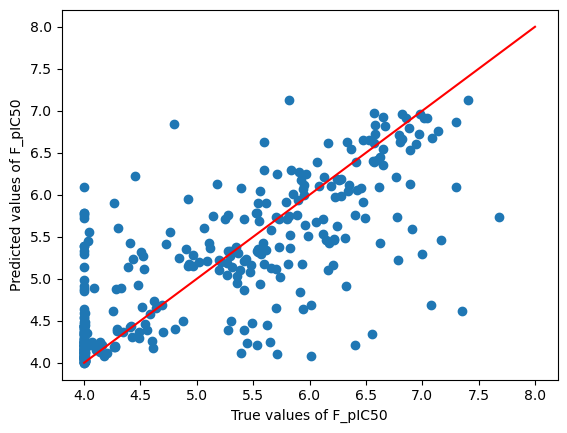

In [10]:
plt.scatter(
    split_featurised_dataset["test"]["log10_f_avg_IC50"],
    preds[current_model+"::log10_f_avg_IC50"],
)
plt.plot([4, 8], [4, 8], c='r')
plt.xlabel("True values of F_pIC50")
plt.ylabel("Predicted values of F_pIC50")
plt.show()
# print(model.config)

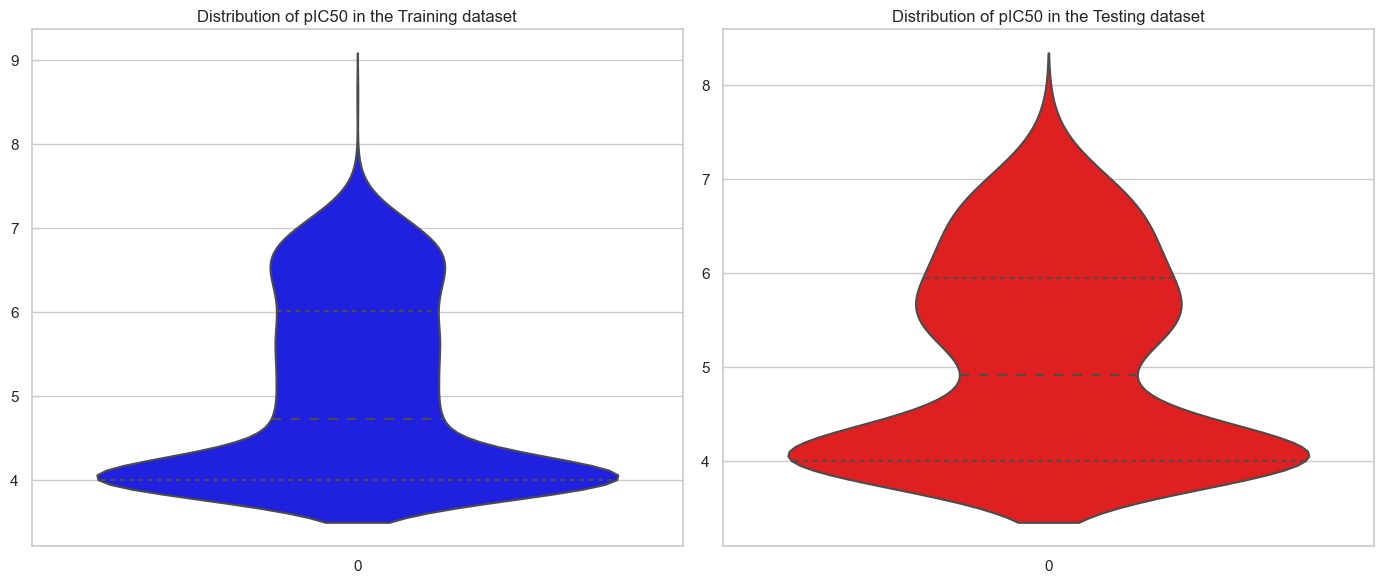

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming split_featurised_dataset is your dataset with "train" and "test" subsets
# Replace 'log10_f_avg_IC50' with your actual variable name

sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# Plot the first violin plot (Training dataset)
sns.violinplot(split_featurised_dataset["train"]["log10_f_avg_IC50"], color='blue', inner='quartile', label="Training dataset", ax=axes[0])
axes[0].set_title('Distribution of pIC50 in the Training dataset')

# Plot the second violin plot (Testing dataset)
sns.violinplot(split_featurised_dataset["test"]["log10_f_avg_IC50"], color='red', inner='quartile', label="Testing dataset",  ax=axes[1])
axes[1].set_title('Distribution of pIC50 in the Testing dataset')

# Adjust layout
plt.tight_layout()
plt.show()

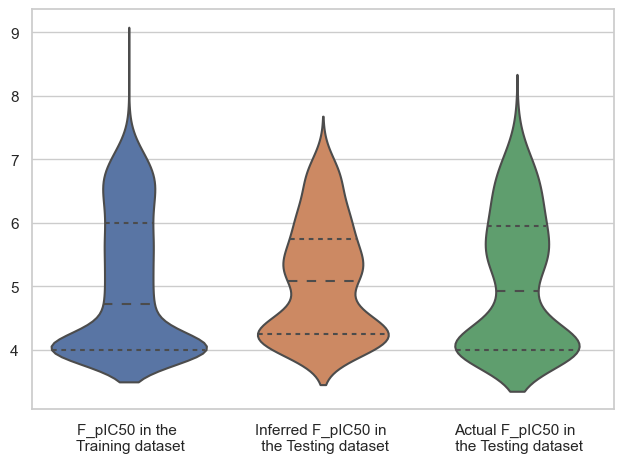

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

violin_plot = sns.violinplot(data = [split_featurised_dataset["train"]["log10_f_avg_IC50"], 
                                     preds[current_model+"::log10_f_avg_IC50"],
                                     split_featurised_dataset["test"]["log10_f_avg_IC50"]]
                             , inner='quartile')
violin_plot.set_xticklabels(['F_pIC50 in the \n Training dataset', 'Inferred F_pIC50 in \n the Testing dataset', 'Actual F_pIC50 in \n the Testing dataset'])



# Adjust layout
plt.tight_layout()
plt.show()

In [13]:
# # Using drugMLpractical environment
# # Need python < 3.12 so I have 3.11, then just pip install matplotlib, pip install 'molflux[rdkit]'

# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt

# import rdkit.Chem as Chem
# from rdkit.Chem import AllChem
# from rdkit.Chem import Descriptors

# def read_and_clean_data(path):
#     df = pd.read_csv(path)
#     df = df.dropna(subset=['r_avg_IC50', 'f_avg_IC50'], how='all') # removing na values
#     df = df.drop_duplicates(subset=['SMILES'], keep='first') # removing the duplicates --> show example? 
#     df = df[df['f_avg_IC50']<=100] # removes extreme outliers
#     dfs = df[['SMILES','CID','f_avg_IC50','r_avg_IC50']]
#     return df, dfs

# df, dfs = read_and_clean_data('raw_df_notest.csv')


/var/folders/0n/tfjdd1157tj4k9w96w40kyn00000gn/T/ipykernel_25459/2188881279.py:13: DtypeWarning: Columns (4,7,8,10,11,12,13,14,15,16,17,18,19,20,28,29,30,31,32,33,34,35,36,37,41,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,67,68,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,250,254,255,256,257,258,259,260,265,266,267,268,269,270,271,276,277) have mixed types. Specify dtype option on im

In [14]:
# import numpy as np
# dfs["log10_f_avg_IC50"] = - np.log10(dfs["f_avg_IC50"]*1e-6) 

# from datasets import Dataset

# import pandas as pd
# data = Dataset.from_pandas(dfs)
# print(data)
# data[0]

Dataset({
    features: ['SMILES', 'CID', 'f_avg_IC50', 'r_avg_IC50', 'log10_f_avg_IC50', '__index_level_0__'],
    num_rows: 1713
})


/var/folders/0n/tfjdd1157tj4k9w96w40kyn00000gn/T/ipykernel_25459/2851387142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs["log10_f_avg_IC50"] = - np.log10(dfs["f_avg_IC50"]*1e-6)


{'SMILES': 'N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1',
 'CID': 'DAR-DIA-23aa0b97-8',
 'f_avg_IC50': 54.272963984987776,
 'r_avg_IC50': None,
 'log10_f_avg_IC50': 4.265416459843516,
 '__index_level_0__': 24}

In [15]:
# # Exctracting features

# from datasets import Dataset
# import pandas as pd
# data = Dataset.from_pandas(dfs)


# from molflux.datasets import featurise_dataset
# from molflux.features import load_from_dicts as load_representations_from_dicts

# featuriser = load_representations_from_dicts(
#     [
#         {"name" :'mhfp'}, # 'presets' : {'length': 1024} MHFP6 (MinHash fingerprint, up to six bonds) is a molecular fingerprint which encodes detailed substructures
#         {"name" :'rdkit_descriptors_2d'}, # values of the 2D descriptor, each descriptor as its own feature.
#         #{"name": "morgan", 'presets': {'radius': 2, 'n_bits': 2048,}},             
#         #{"name": "maccs_rdkit"}, # MACCS keys are 166 bit structural key descriptors in which each bit is associated with a SMARTS pattern
#         #{"name" : "topological"}, # Daylight like fingerprints
#         #{"name" :'avalon'}, # Avalon fingerprint 
#         #{"name" :'layered'}, # topological (Daylight like) fingerprint for a molecule using a layer-based hashing algorithm
#         #{"name" :'mhfp_unfolded'}, # Featurises the input molecules as unfolded MinHash fingerprints
#         #{"name" :'pattern'}, # identifies features in the molecule by doing substructure searches using a small number of very generic SMARTS patterns
#         #{"name" :'toxicophores'} # Calculates toxicophore substructure matches
#         #{"name" :'atom_pair_unfolded'}, # error message: Error processing sample 'N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1'  
#         #{"name" :'drfp'} # error message: Error processing sample 'N#Cc1cccc(NC(=O)Nc2cncc(N)c2)c1'              
#     ]
# )

# featurised_dataset = featurise_dataset(data, column="SMILES", representations=featuriser)

# print(featurised_dataset)

Map:   0%|          | 0/1713 [00:00<?, ? examples/s]

Dataset({
    features: ['SMILES', 'CID', 'f_avg_IC50', 'r_avg_IC50', 'log10_f_avg_IC50', '__index_level_0__', 'SMILES::mhfp', 'SMILES::rdkit_descriptors_2d::MaxAbsEStateIndex', 'SMILES::rdkit_descriptors_2d::MaxEStateIndex', 'SMILES::rdkit_descriptors_2d::MinAbsEStateIndex', 'SMILES::rdkit_descriptors_2d::MinEStateIndex', 'SMILES::rdkit_descriptors_2d::qed', 'SMILES::rdkit_descriptors_2d::SPS', 'SMILES::rdkit_descriptors_2d::MolWt', 'SMILES::rdkit_descriptors_2d::HeavyAtomMolWt', 'SMILES::rdkit_descriptors_2d::ExactMolWt', 'SMILES::rdkit_descriptors_2d::NumValenceElectrons', 'SMILES::rdkit_descriptors_2d::NumRadicalElectrons', 'SMILES::rdkit_descriptors_2d::MaxPartialCharge', 'SMILES::rdkit_descriptors_2d::MinPartialCharge', 'SMILES::rdkit_descriptors_2d::MaxAbsPartialCharge', 'SMILES::rdkit_descriptors_2d::MinAbsPartialCharge', 'SMILES::rdkit_descriptors_2d::FpDensityMorgan1', 'SMILES::rdkit_descriptors_2d::FpDensityMorgan2', 'SMILES::rdkit_descriptors_2d::FpDensityMorgan3', 'SMILES:

In [16]:
# from molflux.datasets import split_dataset
# from molflux.splits import load_from_dict as load_split_from_dict

# shuffle_strategy = load_split_from_dict(
#     {
#         "name": "shuffle_split",
#         "presets": {
#             "train_fraction": 0.8,
#             "validation_fraction": 0.0,
#             "test_fraction": 0.2,
#         }
#     }
# )

# split_featurised_dataset = next(split_dataset(featurised_dataset, shuffle_strategy))

# print(split_featurised_dataset)

DatasetDict({
    train: Dataset({
        features: ['SMILES', 'CID', 'f_avg_IC50', 'r_avg_IC50', 'log10_f_avg_IC50', '__index_level_0__', 'SMILES::mhfp', 'SMILES::rdkit_descriptors_2d::MaxAbsEStateIndex', 'SMILES::rdkit_descriptors_2d::MaxEStateIndex', 'SMILES::rdkit_descriptors_2d::MinAbsEStateIndex', 'SMILES::rdkit_descriptors_2d::MinEStateIndex', 'SMILES::rdkit_descriptors_2d::qed', 'SMILES::rdkit_descriptors_2d::SPS', 'SMILES::rdkit_descriptors_2d::MolWt', 'SMILES::rdkit_descriptors_2d::HeavyAtomMolWt', 'SMILES::rdkit_descriptors_2d::ExactMolWt', 'SMILES::rdkit_descriptors_2d::NumValenceElectrons', 'SMILES::rdkit_descriptors_2d::NumRadicalElectrons', 'SMILES::rdkit_descriptors_2d::MaxPartialCharge', 'SMILES::rdkit_descriptors_2d::MinPartialCharge', 'SMILES::rdkit_descriptors_2d::MaxAbsPartialCharge', 'SMILES::rdkit_descriptors_2d::MinAbsPartialCharge', 'SMILES::rdkit_descriptors_2d::FpDensityMorgan1', 'SMILES::rdkit_descriptors_2d::FpDensityMorgan2', 'SMILES::rdkit_descriptors_2d

In [17]:
# from molflux.modelzoo import load_model

# model = load_model(name="random_forest_regressor")

# print(model)

Model(
	name: "random_forest_regressor",
	tag: "random_forest_regressor",
	description: """
This is an sklearn random forest regressor model.

A random forest is a meta estimator that fits a number of classifying
decision trees on various sub-samples of the dataset and uses averaging
to improve the predictive accuracy and control over-fitting.
The sub-sample size is controlled with the `max_samples` parameter if
`bootstrap=True` (default), otherwise the whole dataset is used to build
each tree.
""",
	config signature: __init__(self, x_features: List[str] = <factory>, y_features: List[str] = <factory>, train_features: Union[List[str], Dict[str, List[str]], NoneType] = None, n_estimators: int = 100, criterion: Literal['squared_error', 'absolute_error', 'friedman_mse', 'poisson'] = 'squared_error', max_depth: Optional[int] = None, min_samples_split: Union[int, float] = 2, min_samples_leaf: Union[int, float] = 1, min_weight_fraction_leaf: float = 0.0, max_features: Union[float, Literal['sq

In [18]:
# current_model = 'random_forest_regressor'

# import json

# from molflux.modelzoo import load_from_dict as load_model_from_dict
# from molflux.metrics import load_suite

# import matplotlib.pyplot as plt

# model = load_model_from_dict(
#     {
#         "name": current_model,
#         "config": {
#             "x_features": ['SMILES::mhfp', 'SMILES::rdkit_descriptors_2d::ExactMolWt', 'SMILES::rdkit_descriptors_2d::BCUT2D_LOGPLOW'],
#             "y_features": ["log10_f_avg_IC50"],
#             # 'n_estimators': 200
    
            
#         }
#     }
# )

# model.train(split_featurised_dataset["train"])

## 7. Results

Metrics, plot distribution of data in training vs testing sets --> how the algo captures & reproduces the distrib of data?

{
    "explained_variance": 0.65,
    "max_error": 2.18,
    "mean_absolute_error": 0.43,
    "mean_squared_error": 0.4,
    "root_mean_squared_error": 0.63,
    "median_absolute_error": 0.27,
    "r2": 0.65,
    "spearman::correlation": 0.79,
    "spearman::p_value": 0.0,
    "pearson::correlation": 0.81,
    "pearson::p_value": 0.0
}


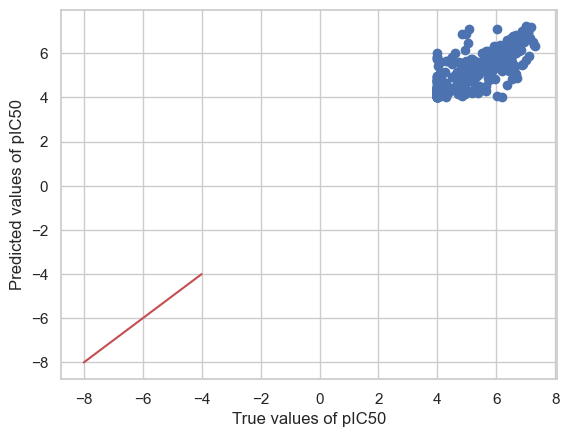

{'x_features': ['SMILES::mhfp', 'SMILES::rdkit_descriptors_2d::ExactMolWt', 'SMILES::rdkit_descriptors_2d::BCUT2D_LOGPLOW'], 'y_features': ['log10_f_avg_IC50'], 'train_features': None, 'n_estimators': 100, 'criterion': 'squared_error', 'max_depth': None, 'min_samples_split': 2, 'min_samples_leaf': 1, 'min_weight_fraction_leaf': 0.0, 'max_features': 1.0, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'bootstrap': True, 'oob_score': False, 'n_jobs': None, 'random_state': None, 'verbose': 0, 'warm_start': False, 'ccp_alpha': 0.0, 'max_samples': None}


In [19]:
# preds = model.predict(split_featurised_dataset["test"])

# regression_suite = load_suite("regression")

# scores = regression_suite.compute(
#     references=split_featurised_dataset["test"]["log10_f_avg_IC50"],
#     predictions=preds[current_model+"::log10_f_avg_IC50"],
# )

# print(json.dumps({k: round(v, 2) for k, v in scores.items()}, indent=4))

# plt.scatter(
#     split_featurised_dataset["test"]["log10_f_avg_IC50"],
#     preds[current_model+"::log10_f_avg_IC50"],
# )
# plt.plot([-8, -4], [-8, -4], c='r')
# plt.xlabel("True values of pIC50")
# plt.ylabel("Predicted values of pIC50")
# plt.show()
# print(model.config)

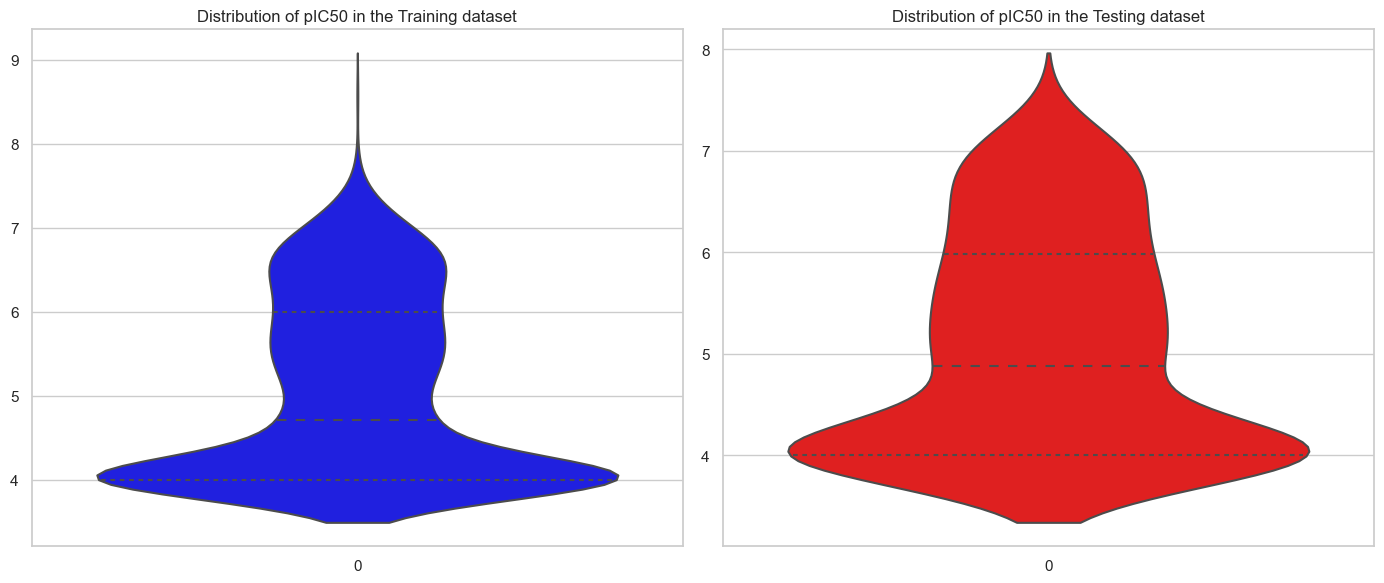

In [20]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming split_featurised_dataset is your dataset with "train" and "test" subsets
# # Replace 'log10_f_avg_IC50' with your actual variable name

# sns.set(style="whitegrid")
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# # Plot the first violin plot (Training dataset)
# sns.violinplot(split_featurised_dataset["train"]["log10_f_avg_IC50"], color='blue', inner='quartile', label="Training dataset", ax=axes[0])
# axes[0].set_title('Distribution of pIC50 in the Training dataset')

# # Plot the second violin plot (Testing dataset)
# sns.violinplot(split_featurised_dataset["test"]["log10_f_avg_IC50"], color='red', inner='quartile', label="Testing dataset",  ax=axes[1])
# axes[1].set_title('Distribution of pIC50 in the Testing dataset')

# # Adjust layout
# plt.tight_layout()
# plt.show()

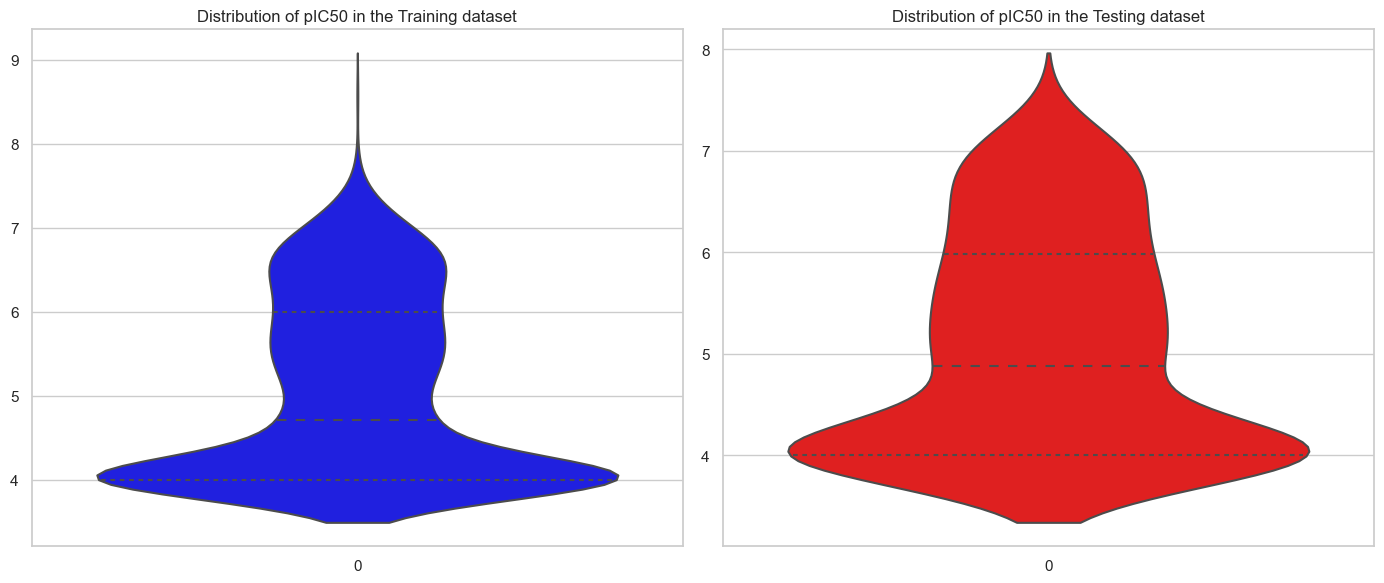

In [21]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Assuming split_featurised_dataset is your dataset with "train" and "test" subsets
# # Replace 'log10_f_avg_IC50' with your actual variable name

# sns.set(style="whitegrid")
# fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

# # Plot the first violin plot (Training dataset)
# sns.violinplot(split_featurised_dataset["train"]["log10_f_avg_IC50"], color='blue', inner='quartile', label="Training dataset", ax=axes[0])
# axes[0].set_title('Distribution of pIC50 in the Training dataset')

# # Plot the second violin plot (Testing dataset)
# sns.violinplot(split_featurised_dataset["test"]["log10_f_avg_IC50"], color='red', inner='quartile', label="Testing dataset",  ax=axes[1])
# axes[1].set_title('Distribution of pIC50 in the Testing dataset')

# # Adjust layout
# plt.tight_layout()
# plt.show()

In [22]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# violin_plot = sns.violinplot(data = [split_featurised_dataset["train"]["log10_f_avg_IC50"], 
#                                      ,
#                                      split_featurised_dataset["train"]["log10_f_avg_IC50"]]
#                              , inner='quartile', label="Training dataset", ax=axes[0])
# violin_plot.set_xticklabels(['pIC50 in the \n Training dataset', 'Inferred pIC50 in \n the Testing dataset', 'Actual pIC50 in \n the Testing dataset'])



# # Adjust layout
# plt.tight_layout()
# plt.show()

SyntaxError: invalid syntax (3524186014.py, line 5)